In [12]:
# Importing the necessary modules
# This section needs to be run twice in order to properly import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# My questions:
# # 3) What is the average cart value per customer?
#     ... in the Northeast?
#     ... in the South?
#     ... in the Midwest?
#     ... in the Southwest?
#     ... in the Northwest?
#     ... outside the contiguous US states?
#
# 6) What is the sales volume by region?



In [13]:
# Loading the file data in

sales_df = pd.read_csv('sales.csv')
products_df = pd.read_csv('products.csv')
customers_df = pd.read_csv('customers.csv')
cities_df = pd.read_csv('cities.csv')
countries_df = pd.read_csv('countries.csv')


In [14]:
# Region mapping dictionary

region_mapping = {
    'Northeast': [
        'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 
        'Vermont', 'New Jersey', 'New York', 'Pennsylvania'
    ],
    'Midwest': [
        'Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa',
        'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'
    ],
    'South': [
        'Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 
        'South Carolina', 'Virginia', 'West Virginia', 'Alabama', 'Kentucky',
        'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'
    ],
    'West': [
        'Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico',
        'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington'
    ]
}

non_contiguous = ['Alaska', 'Hawaii']

# Converting region_mapping to state-to-region format

state_to_region = {}
for region, states in region_mapping.items():
    for state in states:
        state_to_region[state] = region

In [15]:
# Adding a function to get a state from a zip code
def get_state_from_zipcode(zipcode):
    # Converting the zipcode into a string, taking only the first 3 digits (zip3)
    zip3 = str(zipcode)[:3]

    # Zipcode ranges for each state
    # Sourced from USPS' website
    zip_ranges = {
        'Massachusetts': ['010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027'],
        'New Hampshire': ['030', '031', '032', '033', '034', '035', '036', '037', '038'],
        'Maine': ['039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049'],
        'Vermont': ['050', '051', '052', '053', '054', '055', '056', '057', '058', '059'],
        'Connecticut': ['060', '061', '062', '063', '064', '065', '066', '067', '068', '069'],
        'Rhode Island': ['028', '029'],
        'New York': ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149'],
        'New Jersey': ['070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089'],
        'Pennsylvania': ['150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196'],
        'Delaware': ['197', '198', '199'],
        'District of Columbia': ['200', '201', '202', '203', '204', '205'],
        'Virginia': ['220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246'],
        'West Virginia': ['247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268'],
        'North Carolina': ['270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289'],
        'South Carolina': ['290', '291', '292', '293', '294', '295', '296', '297', '298', '299'],
        'Georgia': ['300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319'],
        'Florida': ['320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349'],
        'Alabama': ['350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369'],
        'Tennessee': ['370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385'],
        'Kentucky': ['400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427'],
        'Ohio': ['430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458'],
        'Indiana': ['460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479'],
        'Michigan': ['480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499'],
        'Iowa': ['500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519', '520', '521', '522', '523', '524', '525', '526', '527', '528'],
        'Wisconsin': ['530', '531', '532', '533', '534', '535', '536', '537', '538', '539', '540', '541', '542', '543', '544', '545', '546', '547', '548', '549'],
        'Minnesota': ['550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '560', '561', '562', '563', '564', '565', '566', '567'],
        'South Dakota': ['570', '571', '572', '573', '574', '575', '576', '577'],
        'North Dakota': ['580', '581', '582', '583', '584', '585', '586', '587', '588'],
        'Montana': ['590', '591', '592', '593', '594', '595', '596', '597', '598', '599'],
        'Illinois': ['600', '601', '602', '603', '604', '605', '606', '607', '608', '609', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629'],
        'Missouri': ['630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '640', '641', '642', '643', '644', '645', '646', '647', '648', '649', '650', '651', '652', '653', '654', '655', '656', '657', '658'],
        'Kansas': ['660', '661', '662', '663', '664', '665', '666', '667', '668', '669', '670', '671', '672', '673', '674', '675', '676', '677', '678', '679'],
        'Nebraska': ['680', '681', '682', '683', '684', '685', '686', '687', '688', '689', '690', '691', '692', '693'],
        'Louisiana': ['700', '701', '702', '703', '704', '705', '706', '707', '708', '709', '710', '711', '712', '713', '714'],
        'Arkansas': ['716', '717', '718', '719', '720', '721', '722', '723', '724', '725', '726', '727', '728', '729'],
        'Oklahoma': ['730', '731', '732', '733', '734', '735', '736', '737', '738', '739', '740', '741', '742', '743', '744', '745', '746', '747', '748', '749'],
        'Texas': ['750', '751', '752', '753', '754', '755', '756', '757', '758', '759', '760', '761', '762', '763', '764', '765', '766', '767', '768', '769', '770', '771', '772', '773', '774', '775', '776', '777', '778', '779', '780', '781', '782', '783', '784', '785', '786', '787', '788', '789', '790', '791', '792', '793', '794', '795', '796', '797', '798', '799'],
        'Colorado': ['800', '801', '802', '803', '804', '805', '806', '807', '808', '809', '810', '811', '812', '813', '814', '815', '816'],
        'Wyoming': ['820', '821', '822', '823', '824', '825', '826', '827', '828', '829', '830', '831'],
        'Idaho': ['832', '833', '834', '835', '836', '837', '838'],
        'Utah': ['840', '841', '842', '843', '844', '845', '846', '847'],
        'New Mexico': ['870', '871', '872', '873', '874', '875', '876', '877', '878', '879', '880', '881', '882', '883', '884'],
        'Arizona': ['850', '851', '852', '853', '854', '855', '856', '857', '858', '859', '860', '861', '862', '863', '864', '865'],
        'Nevada': ['890', '891', '892', '893', '894', '895', '896', '897', '898', '899'],
        'California': ['900', '901', '902', '903', '904', '905', '906', '907', '908', '909', '910', '911', '912', '913', '914', '915', '916', '917', '918', '919', '920', '921', '922', '923', '924', '925', '926', '927', '928', '929', '930', '931', '932', '933', '934', '935', '936', '937', '938', '939', '940', '941', '942', '943', '944', '945', '946', '947', '948', '949', '950', '951', '952', '953', '954', '955', '956', '957', '958', '959', '960', '961'],
        'Hawaii': ['967', '968'],
        'Oregon': ['970', '971', '972', '973', '974', '975', '976', '977', '978', '979'],
        'Washington': ['980', '981', '982', '983', '984', '985', '986', '987', '988', '989', '990', '991', '992', '993', '994'],
        'Alaska': ['995', '996', '997', '998', '999']
    }

    # Converting from zip3 to state
    zip_to_state = {}
    for state, zip_list in zip_ranges.items():
        for zip3_prefix in zip_list:
            zip_to_state[zip3_prefix] = state
    return zip_to_state.get(zip3)

In [16]:
# Calculating the actual price of each sale (accounting for quantity and discount)
sales_with_products = sales_df.merge(products_df[['ProductID', 'Price']], on='ProductID')
sales_with_products['actual_price'] = (
    sales_with_products['Price'] * 
    sales_with_products['Quantity'] * 
    (1 - sales_with_products['Discount'])
)

In [17]:
# Calculating cart values by grouping by transaction
cart_values = (sales_with_products
    .groupby(['TransactionNumber', 'CustomerID'])['actual_price']
    .sum()
    .reset_index())


In [18]:
# Getting customer location information
customer_locations = (customers_df
    .merge(cities_df, on='CityID')
    .merge(countries_df, on='CountryID')
)

# Adding state based on zipcode
customer_locations['State'] = customer_locations['Zipcode'].apply(get_state_from_zipcode)

# Adding region based on state
customer_locations['Region'] = customer_locations['State'].map(state_to_region)

# Adding non-contiguous state flag
customer_locations['IsContiguous'] = ~customer_locations['State'].isin(non_contiguous)

# Filtering for US customers using CountryName
us_customers = customer_locations[customer_locations['CountryName'] == 'United States'].copy()



In [19]:
# Merging cart values with customer locations
cart_values_with_regions = cart_values.merge(
    us_customers[['CustomerID', 'State', 'Region', 'IsContiguous']], 
    on='CustomerID'
)

# Calculating stats by region
regional_stats = (cart_values_with_regions
    .groupby('Region')
    .agg({
        'actual_price': ['mean', 'count'],
        'CustomerID': 'nunique'
    })
    .round(2)
)

# Renaming columns for clarity
regional_stats.columns = ['Average Cart Value', 'Total Sales', 'Unique Customers']

# Displaying the results
print(regional_stats)

           Average Cart Value  Total Sales  Unique Customers
Region                                                      
Midwest                644.00       205182             20255
Northeast              641.73       123997             12220
South                  638.31       303132             29918
West                   636.97       230575             22812


In [20]:
# Detailed cart value statistics by region
cart_value_details = (cart_values_with_regions
    .groupby('Region')
    .agg({
        'actual_price': [
            'mean',
            'median',
            'min',
            'max',
            'std',
            'count'      
        ]
    })
    .round(2)
)

print(cart_value_details)

          actual_price                                       
                  mean  median   min      max     std   count
Region                                                       
Midwest         644.00  493.96  0.04  2496.89  547.71  205182
Northeast       641.73  492.79  0.04  2496.89  547.25  123997
South           638.31  487.71  0.04  2496.89  546.25  303132
West            636.97  488.33  0.04  2496.89  543.99  230575


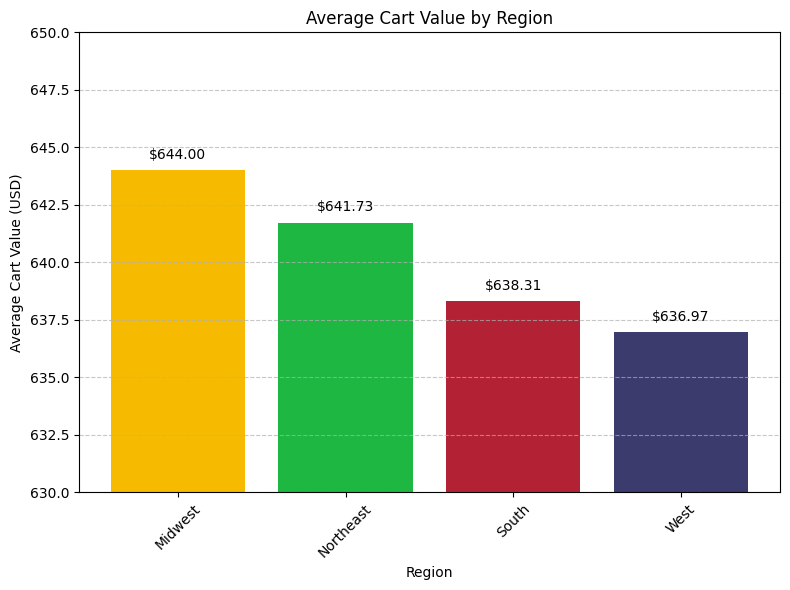

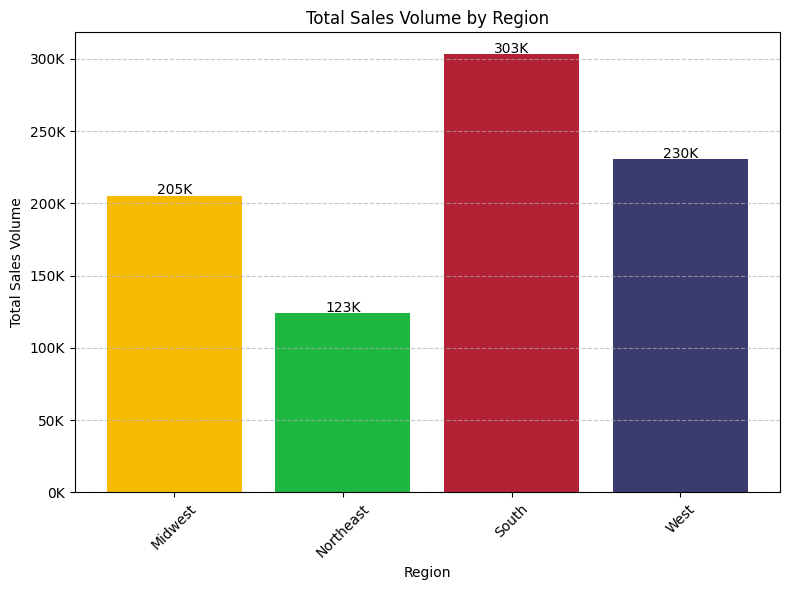

In [21]:
# Adding color dictionary
colors = ['#F6BB00','#1EB742','#B32134','#3B3B6D']

# First plot: Average Cart Value by Region
plt.figure(figsize=(8, 6))
regions = regional_stats.index
avg_cart_values = regional_stats['Average Cart Value']
plt.bar(regions, avg_cart_values, color=colors)
plt.title('Average Cart Value by Region')
plt.xlabel('Region')
plt.ylabel('Average Cart Value (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.ylim(630, 650)
for i, v in enumerate(avg_cart_values):
    plt.text(i, v + 0.5, f'${v:.2f}', ha='center')
plt.tight_layout()
plt.savefig('average_cart_value.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Second plot: Total Sales Volume by Region
plt.figure(figsize=(8, 6))
sales = regional_stats['Total Sales']
plt.bar(regions, sales, color=colors)
plt.title('Total Sales Volume by Region')
plt.ylabel('Total Sales Volume')
plt.xlabel('Region')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Format large numbers with K
for i, v in enumerate(sales):
    plt.text(i, v + 1000, f'{int(v/1000)}K', ha='center')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
plt.tight_layout()
plt.savefig('total_sales_volume.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


20:35:25 - cmdstanpy - INFO - Chain [1] start processing
20:35:29 - cmdstanpy - INFO - Chain [1] done processing


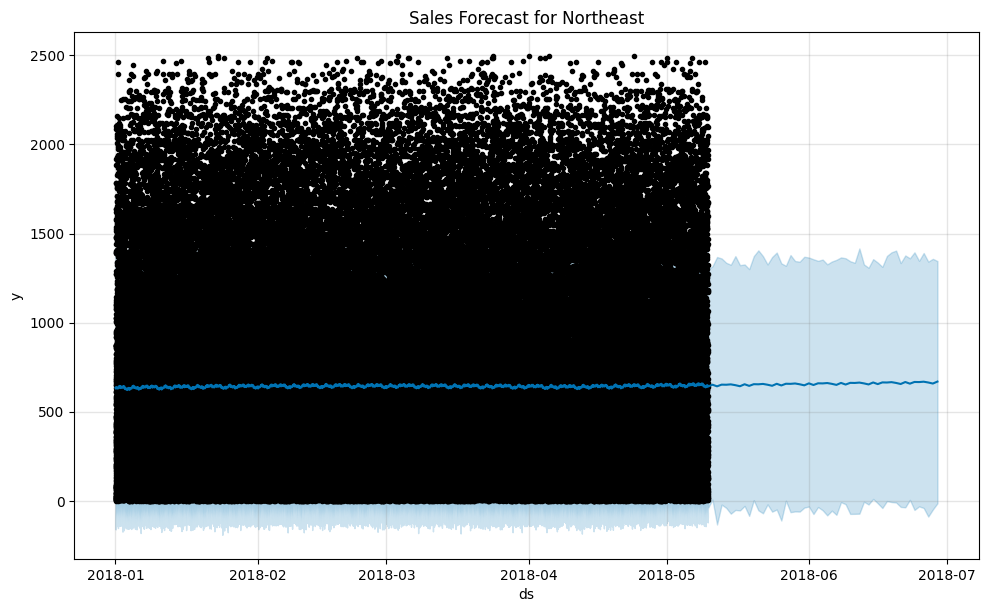

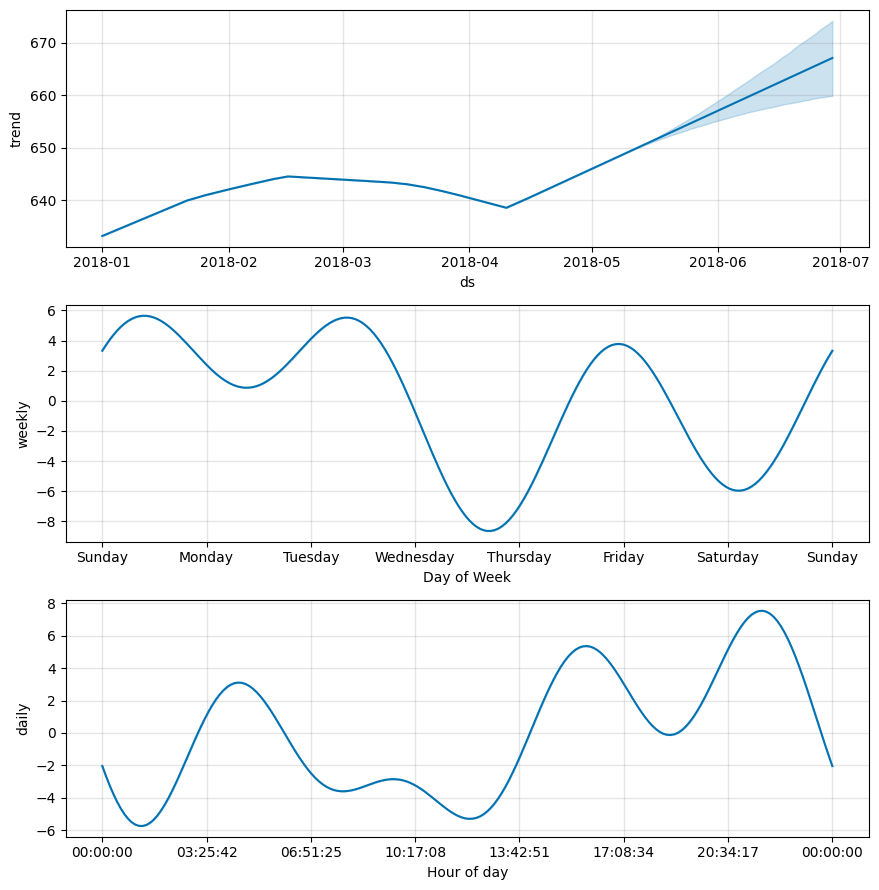

In [ ]:
# Creating relevant data frame for Prophet
sales_prophet = (cart_values_with_regions
    .assign(SalesDate=pd.to_datetime(sales_with_products['SalesDate']))
    .groupby(['Region', 'SalesDate'])['actual_price']
    .sum()
    .reset_index()
)

# Converting to correct Prophet format
region_name = 'Northeast'
region_data = sales_prophet[sales_prophet['Region'] == region_name].copy()
region_data = region_data.rename(columns={'SalesDate':'ds', 'actual_price':'y'})

# Initialize and fit model
m = Prophet()
m.fit(region_data)

# Creating future data frame and making a forecast
future = m.make_future_dataframe(periods=50)
forecast = m.predict(future)

# Plotting forecast
fig = m.plot(forecast)
plt.title(f'Sales Forecast for {region_name}')
plt.savefig(f'salesforecast_{region_name}.png', dpi=300)
plt.show()

# Plotting components
fig = m.plot_components(forecast)
plt.savefig(f'components_{region_name}.png', dpi=300)
plt.show()
